In [1]:
import os
import logging
from pathlib import Path
import datetime

from tqdm import tqdm
import numpy as np
import math
import pandas as pd
import random

import torch
from torch.utils.data import DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

import torch.nn as nn 
from torch.nn.utils import parameters_to_vector
import torch.optim as optim
from torchinfo import summary

from brevitas.export import export_onnx_qcdq

import torchmetrics

import cv2

import config
import dataset_dfire
import datasets
import models
import loss
import metrics
import train_epoch
import val_epoch
import utils

In [2]:
#torch.cuda.empty_cache()

# Logger

In [3]:
log_path = config.LOGS_FOLDER

logger = logging.getLogger("GonLogger")
logger.propagate = False
logger.setLevel(logging.INFO)
file_handler = logging.FileHandler(log_path + 'logfile.log')
formatter = logging.Formatter('%(message)s')
file_handler.setFormatter(formatter)

# add file handler to logger
logger.addHandler(file_handler)

logger.info('BED Classifier XS Tiny.\n' +  
            '\tOne Head.\n' +
            '\tAdding best mean F1 save.\n' +
            '\t256 Normalization.\n' +
            '\tWeighted for Precision.\n' +
            '\tModules.\n'+ 
            '\tLosses and Metrics Loggers.\n' +
            '\tBrevitas with All Layers defined in the Model, but Dropout and Flatten.\n' +
            '\tBit width of Big Layers separated.\n' +
            '\tQuantIdentity with Uint8Act added and constant scale factor.\n' +
            '\tWeights with Per Channel Quant.\n' +
            '\tIntBias, Internal Scale with FixedPoint.\n' +
            f'\tFixed Point: {config.FIXED_POINT}.\n' +
            f'\tFuse BN: {config.FUSE_BN}.\n' +
            f'\tWeights bit width = {config.WEIGHTS_BIT_WIDTH}.\n' +
            f'\tBig Layers Weights bit width = {config.BIG_LAYERS_WEIGHTS_BIT_WIDTH}.\n' +
            f'\tActivations bit width = {config.ACTIVATIONS_BIT_WIDTH}.\n' +
            f'\tBias bit width = {config.BIAS_BIT_WIDTH}.\n' +
            f'\t{config.EPOCHS} epochs.\n')

# View Dataset

### Transform

In [4]:
view_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(config.IMG_H, config.IMG_W, p=1),
        ToTensorV2(p=1),
    ]
)

In [5]:
VIEW_BATCH_SIZE = 32

view_dfire_ds = dataset_dfire.DFireDataset(
    img_h=config.IMG_H, 
    img_w=config.IMG_W, 
    img_dir=config.val_imgs, 
    label_dir=config.val_labels, 
    num_classes=config.N_CLASSES,
    ds_len=2*VIEW_BATCH_SIZE,
    transform=view_transform)

view_loader = DataLoader(dataset=view_dfire_ds,
                         batch_size=VIEW_BATCH_SIZE,
                         num_workers=1,
                         pin_memory=True,
                         shuffle=True,
                         drop_last=False)
print(f'Val dataset length: {len(view_dfire_ds)}')

DFire Removed wrong images: 0
DFire empty images: 31
DFire only smoke images: 17
DFire only fire images: 2
DFire smoke and fire images: 14
Val dataset length: 64


# Plot Dataset Pictures

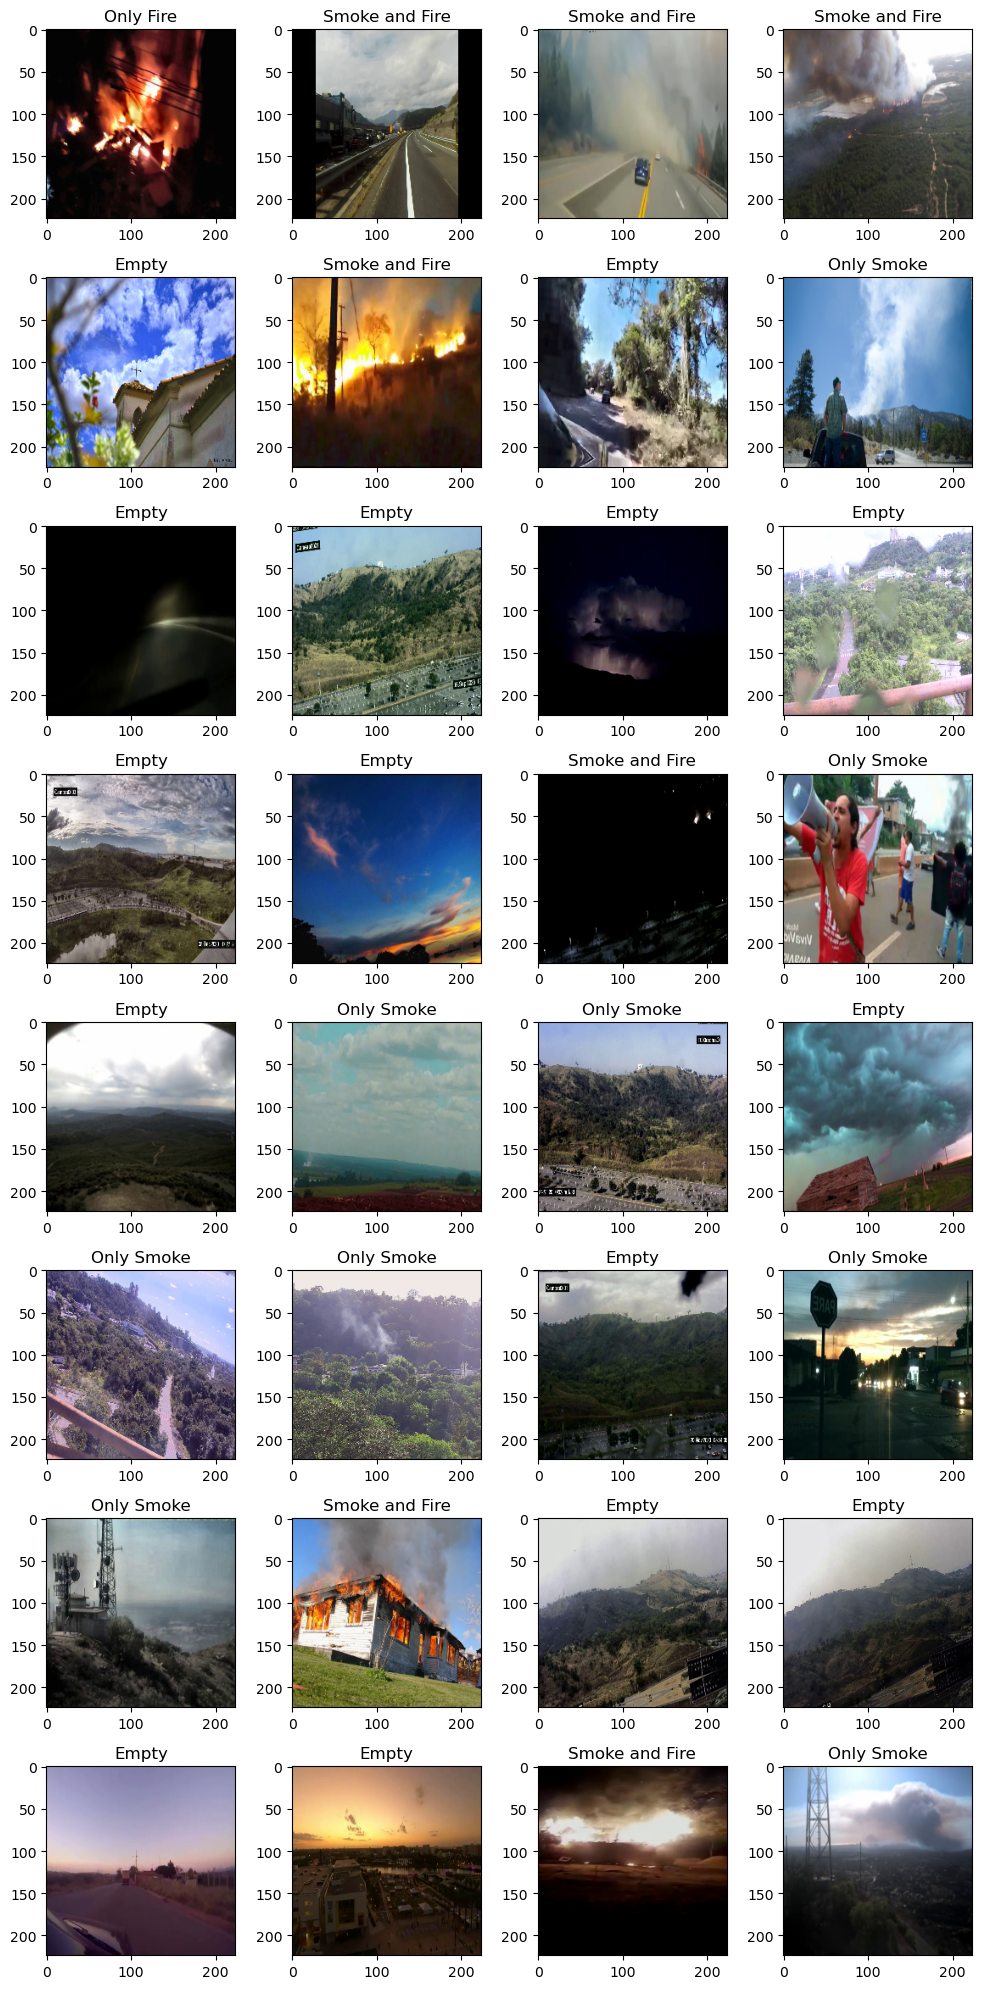

In [6]:
for i, (img, label) in enumerate(view_loader):

    plt.subplots(8,4, figsize=(10, 20))
    
    for idx in range(VIEW_BATCH_SIZE):
        plt.subplot(8, 4, idx+1)
        plt.imshow(img[idx].permute(1, 2, 0))
        title = ""
        if label[idx][0] == 1 and label[idx][1] == 1:
            title += "Smoke and Fire"
        elif label[idx][0] == 1 and label[idx][1] == 0:
            title += "Only Smoke"
        elif label[idx][0] == 0 and label[idx][1] == 1:
            title += "Only Fire"
        else:
            title += "Empty"
        plt.title(title)
        
        if (idx == 31):
            break
    plt.tight_layout()
    plt.show()
    break

# Dataset Setup

In [7]:
train_loader = datasets.get_train_loader()
val_loader = datasets.get_val_loader()


TRAIN DFIRE dataset


Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


DFire Removed wrong images: 0
DFire empty images: 7833
DFire only smoke images: 4681
DFire only fire images: 944
DFire smoke and fire images: 3763

Train DFire dataset len: 17221

TRAIN FASDD UAV dataset
DFire Removed wrong images: 0
DFire empty images: 5994
DFire only smoke images: 2541
DFire only fire images: 105
DFire smoke and fire images: 3911

Train FASDD UAV dataset len: 12551

TRAIN FASDD CV dataset


Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


DFire Removed wrong images: 0
DFire empty images: 19600
DFire only smoke images: 11708
DFire only fire images: 6276
DFire smoke and fire images: 10076

Train FASDD CV dataset len: 47660
Concatenate Train DFire and FASDD UAV datasets
Train dataset len: 29772
Concatenate with FASDD CV dataset
Train dataset len: 77432

TEST DFire dataset
DFire Removed wrong images: 0
DFire empty images: 2005
DFire only smoke images: 1186
DFire only fire images: 220
DFire smoke and fire images: 895

Test dataset len: 4306

TEST FASDD UAV dataset
DFire Removed wrong images: 0
DFire empty images: 1997
DFire only smoke images: 846
DFire only fire images: 35
DFire smoke and fire images: 1303

Test FASDD UAV dataset len: 4181

TEST FASDD CV dataset
DFire Removed wrong images: 0
DFire empty images: 6533
DFire only smoke images: 3902
DFire only fire images: 2091
DFire smoke and fire images: 3358

Test FASDD CV dataset len: 15884
Concatenate Test DFire and FASDD UAV datasets
Test dataset len: 8487
Concatenate with

# Models Setup

In [8]:
if config.MODEL == "BED":
    
    print("Using BED Classifier")
    logger.info("\nUsing BED Classifier")
    fp32_model = models.FUSED_BED_CLASSIFIER(num_classes=config.N_CLASSES).to(config.DEVICE)  
    
    if config.FIXED_POINT == True and config.FUSE_BN == False:
        print("Using Fixed Point Quantizers with BN")
        logger.info("Using Fixed Point Quantizers with BN")
        quant_model = models.QUANT_FixedPoint_BED_CLASSIFIER(
                weight_bw = config.WEIGHTS_BIT_WIDTH,
                act_bw = config.ACTIVATIONS_BIT_WIDTH,
                bias_bw = config.BIAS_BIT_WIDTH,
                num_classes=config.N_CLASSES).to(config.DEVICE)
    elif config.FIXED_POINT == True and config.FUSE_BN == True:
        print("Using Fixed Point Quantizers without BN")
        logger.info("Using Fixed Point Quantizers without BN")
        quant_model = models.QUANT_FixedPoint_NoBN_BED_CLASSIFIER(
                weight_bw = config.WEIGHTS_BIT_WIDTH,
                big_layers_weight_bw = config.BIG_LAYERS_WEIGHTS_BIT_WIDTH,
                act_bw = config.ACTIVATIONS_BIT_WIDTH,
                bias_bw = config.BIAS_BIT_WIDTH,
                num_classes=config.N_CLASSES).to(config.DEVICE)
    else:
        quant_model = models.QUANT_BED_CLASSIFIER(
            weight_bw = config.WEIGHTS_BIT_WIDTH,
            act_bw = config.ACTIVATIONS_BIT_WIDTH,
            bias_bw = config.BIAS_BIT_WIDTH,
            num_classes=config.N_CLASSES).to(config.DEVICE)  
else:
    print("Wrong Model")
    logger.info("Wrong Model")
    raise SystemExit("Wrong Model")

optimizer = optim.Adam(quant_model.parameters(), 
                       lr=config.LEARNING_RATE, 
                       weight_decay=config.WEIGHT_DECAY)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min',
                                                 factor=config.FACTOR, 
                                                 patience=config.PATIENCE, 
                                                 threshold=config.THRES, 
                                                 threshold_mode='abs',
                                                 min_lr=config.MIN_LR)

# MODEL PARAMETERS
n_trainable = sum(p.numel() for p in quant_model.parameters() if p.requires_grad)
print(f'\nTrainable parameters = {n_trainable}')
logger.info(f'\nTrainable parameters = {n_trainable}')

n_params = parameters_to_vector(quant_model.parameters()).numel()
print(f'Total parameters = {n_params}\n')
logger.info(f'Total parameters = {n_params}\n')

Using BED Classifier
Using Fixed Point Quantizers without BN

Trainable parameters = 93297
Total parameters = 93297



### Check Model Shape

In [9]:
in_rand_np = np.random.rand(4, 3, config.IMG_H, config.IMG_W)
in_rand = torch.tensor(in_rand_np, dtype=torch.float32, device=config.DEVICE)
out_test = quant_model(in_rand)
print(f'Model shape is {out_test}')
print(f'BED Model Arquitecture\n{quant_model}')
logger.info(f'Model shape is {out_test}')
logger.info(f'BED Model Arquitecture\n{quant_model}')

/opt/conda/envs/pytorch_brevitas/lib/python3.10/site-packages/torch/_tensor.py:1362: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at /opt/conda/conda-bld/pytorch_1702400410390/work/c10/core/TensorImpl.h:1900.)
  return super().rename(names)


Model shape is tensor([[-0.1790,  0.0818],
        [-0.1773,  0.0776],
        [-0.1783,  0.0833],
        [-0.1774,  0.0776]], device='cuda:0', grad_fn=<AddmmBackward0>)
BED Model Arquitecture
QUANT_FixedPoint_NoBN_BED_CLASSIFIER(
  (model): Sequential(
    (input0): QuantIdentity(
      (input_quant): ActQuantProxyFromInjector(
        (_zero_hw_sentinel): StatelessBuffer()
      )
      (act_quant): ActQuantProxyFromInjector(
        (_zero_hw_sentinel): StatelessBuffer()
        (fused_activation_quant_proxy): FusedActivationQuantProxy(
          (activation_impl): Identity()
          (tensor_quant): RescalingIntQuant(
            (int_quant): IntQuant(
              (float_to_int_impl): RoundSte()
              (tensor_clamp_impl): TensorClamp()
              (delay_wrapper): DelayWrapper(
                (delay_impl): _NoDelay()
              )
            )
            (scaling_impl): ConstScaling(
              (restrict_clamp_scaling): _RestrictClampValue(
                (cl

# Load Pretrained or Initialize Weights

In [10]:
fp32_optimizer = optim.Adam(
    fp32_model.parameters(), 
    lr=config.LEARNING_RATE, 
    weight_decay=config.WEIGHT_DECAY)

fp32_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    fp32_optimizer, 
    mode='min',
    factor=config.FACTOR, 
    patience=config.PATIENCE, 
    threshold=config.THRES, 
    threshold_mode='abs',
    min_lr=config.MIN_LR)

if config.LOAD_MODEL == False:
    if config.MODEL == "BED":
        fp32_model.__initialize_weights__()
        print("Initializing Weights")
        logger.info("Initializing Weights")
else:
    epochs_trained = utils.load_checkpoint(config.LOAD_MODEL_FILE, fp32_model, fp32_optimizer, fp32_scheduler, config.DEVICE)
    logger.info(f"Loading Model. Trained during {epochs_trained} epochs")

Loading Model. Trained during 87 epochs


# Torchinfo: model summary

### Quant Model

In [11]:
print(summary(quant_model, input_size=(1, 3, config.IMG_H, config.IMG_W)))
logger.info("Quant Model Summary")
logger.info(summary(quant_model, input_size=(1, 3, config.IMG_H, config.IMG_W)))

Layer (type:depth-idx)                                                      Output Shape              Param #
QUANT_FixedPoint_NoBN_BED_CLASSIFIER                                        [1, 2]                    --
├─Sequential: 1-1                                                           [1, 2]                    --
│    └─QuantIdentity: 2-1                                                   [1, 3, 224, 224]          --
│    │    └─ActQuantProxyFromInjector: 3-1                                  [1, 3, 224, 224]          --
│    │    └─ActQuantProxyFromInjector: 3-2                                  [1, 3, 224, 224]          --
│    └─QuantReLU: 2-55                                                      --                        (recursive)
│    │    └─ActQuantProxyFromInjector: 3-99                                 --                        (recursive)
│    └─QuantIdentity: 2-3                                                   --                        --
│    │    └─ActQuantProxyFromInj

### FP32 Model

In [12]:
print(summary(fp32_model, input_size=(1, 3, config.IMG_H, config.IMG_W)))
logger.info("Original FP32 Model Summary")
logger.info(summary(fp32_model, input_size=(1, 3, config.IMG_H, config.IMG_W)))

Layer (type:depth-idx)                   Output Shape              Param #
FUSED_BED_CLASSIFIER                     [1, 2]                    --
├─Sequential: 1-1                        [1, 2]                    --
│    └─Conv2d: 2-1                       [1, 32, 224, 224]         896
│    └─ReLU: 2-2                         [1, 32, 224, 224]         --
│    └─Dropout2d: 2-3                    [1, 32, 224, 224]         --
│    └─MaxPool2d: 2-4                    [1, 32, 112, 112]         --
│    └─Conv2d: 2-5                       [1, 16, 112, 112]         4,624
│    └─ReLU: 2-6                         [1, 16, 112, 112]         --
│    └─Dropout2d: 2-7                    [1, 16, 112, 112]         --
│    └─MaxPool2d: 2-8                    [1, 16, 56, 56]           --
│    └─Conv2d: 2-9                       [1, 16, 56, 56]           272
│    └─ReLU: 2-10                        [1, 16, 56, 56]           --
│    └─Conv2d: 2-11                      [1, 32, 56, 56]           4,640
│    └─

# Load Pretrained Weights from FP32 Model to Quant Model

In [13]:
# # Try to load fp32 weights to quant_model
from brevitas import config as brevitas_config

brevitas_config.IGNORE_MISSING_KEYS = True

### Load all Pretrained Weights

In [14]:
for fp32_name, fp32_mod in fp32_model.named_modules():
    for quant_name, quant_mod in  quant_model.named_modules():
        if fp32_name == quant_name:
            print(f'fp32 model name: {fp32_name} - quant model name: {quant_name}')
            if isinstance(fp32_mod, nn.Conv2d):
                if fp32_name == quant_name:
                    quant_mod.load_state_dict(fp32_mod.state_dict())
                    print(f'\t****** Loading weights of Conv2d layer fp32 {fp32_name} into quant {quant_name}')
            elif isinstance(fp32_mod, nn.Linear):
                if fp32_name == quant_name:
                    quant_mod.load_state_dict(fp32_mod.state_dict())
                    print(f'\t****** Loading weights of Linear layer fp32 {fp32_name} into quant {quant_name}')
            else:
                print(f'\t______ Ignore weights or params of layer fp32 {fp32_name} and quant {quant_name}')

fp32 model name:  - quant model name: 
	______ Ignore weights or params of layer fp32  and quant 
fp32 model name: model - quant model name: model
	______ Ignore weights or params of layer fp32 model and quant model
fp32 model name: model.conv1 - quant model name: model.conv1
	****** Loading weights of Conv2d layer fp32 model.conv1 into quant model.conv1
fp32 model name: model.relu1 - quant model name: model.relu1
	______ Ignore weights or params of layer fp32 model.relu1 and quant model.relu1
fp32 model name: model.dropout1 - quant model name: model.dropout1
	______ Ignore weights or params of layer fp32 model.dropout1 and quant model.dropout1
fp32 model name: model.maxpool2 - quant model name: model.maxpool2
	______ Ignore weights or params of layer fp32 model.maxpool2 and quant model.maxpool2
fp32 model name: model.conv2 - quant model name: model.conv2
	****** Loading weights of Conv2d layer fp32 model.conv2 into quant model.conv2
fp32 model name: model.relu2 - quant model name: mod

# Loss Function

In [15]:
if config.LOSS_FN == "BCE":
    print(f'Loss Function: BCE')
    logger.info(f'\nLoss Function: BCE')
    print(f'Smoke Precision Weight: {config.SMOKE_PRECISION_WEIGHT}')
    logger.info(f'Smoke Precision Weight: {config.SMOKE_PRECISION_WEIGHT}')
    loss_fn = loss.BCE_LOSS(device=config.DEVICE, smoke_precision_weight=config.SMOKE_PRECISION_WEIGHT)
else:
    print("Wrong loss function")
    logger.info("Wrong loss function")
    raise SystemExit("Wrong loss function")

Loss Function: BCE
Smoke Precision Weight: 0.8


# Print and Log Config Values

In [16]:
''' ============================
    Print Config Values
============================ '''
print(f'\nDevice: {config.DEVICE}')
print(f'Learning Rate: {config.LEARNING_RATE}')
print(f'Weight Decay: {config.WEIGHT_DECAY}')
print(f'Batch Size: {config.BATCH_SIZE}')
print(f'IMG DIMS: ({config.IMG_H}, {config.IMG_W})')

logger.info(f'\nDevice: {config.DEVICE}')
logger.info(f'Learning Rate: {config.LEARNING_RATE}')
logger.info(f'Weight Decay: {config.WEIGHT_DECAY}')
logger.info(f'Scheduler factor: {config.FACTOR}')
logger.info(f'Scheduler patience: {config.PATIENCE}')
logger.info(f'Scheduler threshold: {config.THRES}')
logger.info(f'Scheduler min learning rate: {config.MIN_LR}')
logger.info(f'Batch Size: {config.BATCH_SIZE}')
logger.info(f'W: {config.IMG_W}\nH: {config.IMG_H}')


Device: cuda
Learning Rate: 0.0001
Weight Decay: 0.0001
Batch Size: 64
IMG DIMS: (224, 224)


# Loss and Metrics Loggers and Plotters

In [17]:
train_losses_logger = utils.LogLosses()
train_metrics_logger = utils.LogMetrics()
lr_logger = utils.LogLR(log_path=config.PLOTS_FOLDER)

val_losses_logger = utils.LogLosses()
val_metrics_logger = utils.LogMetrics()

loss_plotter = utils.PlotMetrics(log_path=config.PLOTS_FOLDER, model_name=config.MODEL, loss_or_metric='Loss')
metrics_plotter = utils.PlotMetrics(log_path=config.PLOTS_FOLDER, model_name=config.MODEL, loss_or_metric='Metric')

# Main Function

In [18]:
def train_loop(model, start_epoch=0):

    ''' ==============================================================
                                TRAINING LOOP
    ============================================================== '''
    start = datetime.datetime.now()
    start_time = start.strftime("%H:%M:%S")
    print(f'\n***Start Training: {start_time}\n')
    logger.info(f'\n***Start Training: {start_time}\n')
    
    # Start with infinite validation loss
    best_valid_loss = np.inf
    best_smoke_precision = 0. #torch.tensor([0.])
    smoke_f1_min_save = 0.9 #torch.tensor([0.9])
    best_mean_f1 = 0.

    #start_epoch = 0
    epochs_plot = []
        
    for epoch in range(start_epoch, config.EPOCHS):

        print(f'\n=== EPOCH {epoch}/{config.EPOCHS-1} ===')
        logger.info(f'\n=== EPOCH {epoch}/{config.EPOCHS-1} ===')
        
        #====================== TRAINING ========================#
        current_lr = train_epoch.get_lr(optimizer=optimizer)
        logger.info(f'Learning Rate = {current_lr}\n')
        lr_logger.log_lr(current_lr)
                
        train_losses, train_metrics = train_epoch.train_fn(
            loader=train_loader, 
            model=model, 
            optimizer=optimizer, 
            loss_fn=loss_fn,
            device=config.DEVICE)
        
        train_losses_logger.update_metrics(train_losses)
        train_metrics_logger.update_metrics(train_metrics)
                
        logger.info(utils.print_metrics_to_logger("TRAIN Stats", train_losses, train_metrics))
        
        #===================== VALIDATING =======================#
        with torch.no_grad():
            val_losses, val_metrics = val_epoch.eval_fn(
                loader=val_loader, 
                model=model,                         
                loss_fn=loss_fn,
                device=config.DEVICE)
            
            scheduler.step(val_losses['Total'])
            
            val_losses_logger.update_metrics(val_losses)
            val_metrics_logger.update_metrics(val_metrics)

            logger.info(utils.print_metrics_to_logger("VAL Stats", val_losses, val_metrics))
            
        epochs_plot.append(epoch)

        loss_plotter.plot_all_metrics(
            train_losses_logger.get_metrics(),
            val_losses_logger.get_metrics(),
            epochs_plot)

        metrics_plotter.plot_all_metrics(
            train_metrics_logger.get_metrics(),
            val_metrics_logger.get_metrics(),
            epochs_plot)

        lr_logger.plot_lr(epochs_plot)
        #======================= SAVING =========================#
        if ( (epoch+1) % 5 ) == 0:
            save_name = config.WEIGHTS_FOLDER + config.MODEL + '_classifier__5epoch.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name) 
            
        if best_valid_loss > val_losses['Total']:
            best_valid_loss = val_losses['Total']
            print(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            logger.info(f"Saving model with new best validation loss: {best_valid_loss:.3f}")
            save_name = config.WEIGHTS_FOLDER + config.MODEL + '_classifier__' + 'best_loss'  + '.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name)  

        # Save model if precision increases and F1 > 0.9
        if ( best_smoke_precision < val_metrics['Precision'][0] ) and ( val_metrics['F1'][0] > smoke_f1_min_save ) :
            best_smoke_precision = val_metrics['Precision'][0]
            print(f"\nSaving model with new best smoke precision: {best_smoke_precision:.3f}")
            logger.info(f"Saving model with new best smoke precision: {best_smoke_precision:.3f}")
            save_precision_name = f'best_smoke__precision={np.round(best_smoke_precision, decimals=4)}__epoch={epoch}'
            save_name = config.WEIGHTS_FOLDER + config.MODEL + '_classifier__' + save_precision_name + '.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name)  
            
        # Save model if precision > 0.9 and recall > 0.9
        if ( val_metrics['Precision'][0] > 0.9 ) and ( val_metrics['Recall'][0] > 0.9 ) :
            print("\nSaving model with precision > 0.9 and recall > 0.9")
            logger.info("Saving model with precision > 0.9 and recall > 0.9")
            save_pre_name = f'smoke__precision={np.round(val_metrics["Precision"][0], decimals=4)}__' 
            save_rec_name = f'recall={np.round(val_metrics["Recall"][0], decimals=4)}__'
            save_pre_rec_name = save_pre_name + save_rec_name + f'epoch={epoch}'
            save_name = config.WEIGHTS_FOLDER + config.MODEL + '_classifier__' + save_pre_rec_name + '.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name) 

        # Save model if best mean F1 increases
        val_f1_mean = (val_metrics['F1'][0] + val_metrics['F1'][1]) / 2
        if (val_f1_mean > best_mean_f1) :
            best_mean_f1 = val_f1_mean
            print(f'Saving model with best Mean F1: {best_mean_f1:.4f}')
            logger.info(f'Saving model with best Mean F1: {best_mean_f1:.4f}')
            save_f1_name = 'best_mean_F1'
            save_name = config.WEIGHTS_FOLDER + config.MODEL + '_classifier__' + save_f1_name + '.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name) 
        
    logger.info('Saving last model')   
    torch.save(model.state_dict(), config.WEIGHTS_FOLDER + 'last_' + config.MODEL + '_classifier.pt') 
    
    #======================= FINISH =========================#
    end = datetime.datetime.now()
    end_time = end.strftime("%H:%M:%S")
    print(f'\n***Script finished: {end_time}\n')  
    print(f'Time elapsed: {end-start}')
    logger.info(f'\n***Script finished: {end_time}\n')  
    logger.info(f'Time elapsed: {end-start}')
    
    return model

# Main execute

In [19]:
if __name__ == "__main__":
    
    print("Starting script\n")
    logger.info("Starting script\n")
    
    qnn_model = train_loop(model=quant_model)

Starting script


***Start Training: 17:48:57


=== EPOCH 0/99 ===
Learning Rate = 0.0001



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [06:19<00:00,  3.19it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.362      |17.643      |10.718      



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.200      |17.431      |10.769      
SMOKE -> Precision: 0.895 - Recall: 0.793 - Accuracy: 0.858 - F1: 0.841
FIRE -> Precision: 0.855 - Recall: 0.961 - Accuracy: 0.934 - F1: 0.905

Saving model with new best validation loss: 28.200
Saving model with best Mean F1: 0.8727

=== EPOCH 1/99 ===
Learning Rate = 0.0001



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.317      |14.635      |8.682       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.37it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.242      |15.595      |10.647      
SMOKE -> Precision: 0.891 - Recall: 0.850 - Accuracy: 0.880 - F1: 0.870
FIRE -> Precision: 0.862 - Recall: 0.966 - Accuracy: 0.939 - F1: 0.911

Saving model with new best validation loss: 26.242
Saving model with best Mean F1: 0.8905

=== EPOCH 2/99 ===
Learning Rate = 0.0001



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.322      |14.040      |8.281       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.28it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.834      |16.300      |10.534      
SMOKE -> Precision: 0.909 - Recall: 0.815 - Accuracy: 0.874 - F1: 0.859
FIRE -> Precision: 0.856 - Recall: 0.976 - Accuracy: 0.939 - F1: 0.912

=== EPOCH 3/99 ===
Learning Rate = 0.0001



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.302      |13.948      |8.354       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.28it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.205      |16.006      |9.199       
SMOKE -> Precision: 0.887 - Recall: 0.840 - Accuracy: 0.874 - F1: 0.863
FIRE -> Precision: 0.887 - Recall: 0.957 - Accuracy: 0.947 - F1: 0.921

Saving model with new best validation loss: 25.205
Saving model with best Mean F1: 0.8917

=== EPOCH 4/99 ===
Learning Rate = 0.0001



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.121      |13.853      |8.268       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.219      |13.938      |7.282       
SMOKE -> Precision: 0.935 - Recall: 0.819 - Accuracy: 0.888 - F1: 0.873
FIRE -> Precision: 0.916 - Recall: 0.949 - Accuracy: 0.955 - F1: 0.932

Saving model with new best validation loss: 21.219
Saving model with best Mean F1: 0.9025

=== EPOCH 5/99 ===
Learning Rate = 0.0001



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.665      |13.529      |8.136       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.824      |14.252      |7.573       
SMOKE -> Precision: 0.939 - Recall: 0.824 - Accuracy: 0.892 - F1: 0.878
FIRE -> Precision: 0.911 - Recall: 0.953 - Accuracy: 0.955 - F1: 0.932
Saving model with best Mean F1: 0.9048

=== EPOCH 6/99 ===
Learning Rate = 0.0001



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:09<00:00,  6.37it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.874      |13.709      |8.165       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.23it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.461      |18.764      |13.696      
SMOKE -> Precision: 0.833 - Recall: 0.893 - Accuracy: 0.865 - F1: 0.862
FIRE -> Precision: 0.819 - Recall: 0.978 - Accuracy: 0.922 - F1: 0.891

=== EPOCH 7/99 ===
Learning Rate = 0.0001



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:12<00:00,  6.29it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.570      |13.592      |7.978       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.36it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.455      |14.807      |7.648       
SMOKE -> Precision: 0.889 - Recall: 0.886 - Accuracy: 0.894 - F1: 0.888
FIRE -> Precision: 0.925 - Recall: 0.928 - Accuracy: 0.952 - F1: 0.926
Saving model with best Mean F1: 0.9071

=== EPOCH 8/99 ===
Learning Rate = 8e-05



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.147      |13.279      |7.868       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.707      |15.337      |7.370       
SMOKE -> Precision: 0.885 - Recall: 0.888 - Accuracy: 0.893 - F1: 0.886
FIRE -> Precision: 0.916 - Recall: 0.955 - Accuracy: 0.957 - F1: 0.935
Saving model with best Mean F1: 0.9105

=== EPOCH 9/99 ===
Learning Rate = 8e-05



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.260      |13.264      |7.996       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.914      |15.458      |12.456      
SMOKE -> Precision: 0.897 - Recall: 0.866 - Accuracy: 0.890 - F1: 0.881
FIRE -> Precision: 0.817 - Recall: 0.987 - Accuracy: 0.924 - F1: 0.894

=== EPOCH 10/99 ===
Learning Rate = 8e-05



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.266      |13.368      |7.897       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.36it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.783      |15.209      |6.574       
SMOKE -> Precision: 0.940 - Recall: 0.808 - Accuracy: 0.885 - F1: 0.869
FIRE -> Precision: 0.946 - Recall: 0.933 - Accuracy: 0.961 - F1: 0.940

=== EPOCH 11/99 ===
Learning Rate = 6.400000000000001e-05



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.911      |13.097      |7.814       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.28it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.117      |17.975      |9.142       
SMOKE -> Precision: 0.846 - Recall: 0.892 - Accuracy: 0.872 - F1: 0.868
FIRE -> Precision: 0.881 - Recall: 0.963 - Accuracy: 0.946 - F1: 0.920

=== EPOCH 12/99 ===
Learning Rate = 6.400000000000001e-05



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.838      |13.145      |7.693       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.521      |15.335      |7.186       
SMOKE -> Precision: 0.882 - Recall: 0.878 - Accuracy: 0.887 - F1: 0.880
FIRE -> Precision: 0.912 - Recall: 0.959 - Accuracy: 0.957 - F1: 0.935

=== EPOCH 13/99 ===
Learning Rate = 6.400000000000001e-05



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.881      |13.079      |7.802       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.531      |16.113      |10.418      
SMOKE -> Precision: 0.887 - Recall: 0.847 - Accuracy: 0.877 - F1: 0.866
FIRE -> Precision: 0.849 - Recall: 0.977 - Accuracy: 0.936 - F1: 0.909

=== EPOCH 14/99 ===
Learning Rate = 5.120000000000001e-05



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.690      |13.002      |7.688       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.860      |14.579      |7.280       
SMOKE -> Precision: 0.912 - Recall: 0.864 - Accuracy: 0.897 - F1: 0.887
FIRE -> Precision: 0.927 - Recall: 0.938 - Accuracy: 0.956 - F1: 0.932

=== EPOCH 15/99 ===
Learning Rate = 5.120000000000001e-05



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.438      |12.678      |7.760       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.230      |14.864      |7.366       
SMOKE -> Precision: 0.938 - Recall: 0.804 - Accuracy: 0.882 - F1: 0.866
FIRE -> Precision: 0.909 - Recall: 0.965 - Accuracy: 0.957 - F1: 0.936

=== EPOCH 16/99 ===
Learning Rate = 5.120000000000001e-05



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.730      |13.002      |7.728       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.253      |13.750      |8.503       
SMOKE -> Precision: 0.941 - Recall: 0.814 - Accuracy: 0.888 - F1: 0.873
FIRE -> Precision: 0.900 - Recall: 0.950 - Accuracy: 0.949 - F1: 0.924

=== EPOCH 17/99 ===
Learning Rate = 4.0960000000000014e-05



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:09<00:00,  6.37it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.400      |12.668      |7.733       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.669      |14.122      |6.546       
SMOKE -> Precision: 0.921 - Recall: 0.866 - Accuracy: 0.902 - F1: 0.893
FIRE -> Precision: 0.934 - Recall: 0.950 - Accuracy: 0.962 - F1: 0.942

Saving model with new best validation loss: 20.669
Saving model with best Mean F1: 0.9175

=== EPOCH 18/99 ===
Learning Rate = 4.0960000000000014e-05



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.301      |12.711      |7.590       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.850      |14.884      |7.966       
SMOKE -> Precision: 0.926 - Recall: 0.834 - Accuracy: 0.890 - F1: 0.877
FIRE -> Precision: 0.890 - Recall: 0.973 - Accuracy: 0.952 - F1: 0.930

=== EPOCH 19/99 ===
Learning Rate = 4.0960000000000014e-05



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.142      |12.677      |7.465       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.25it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.133      |15.183      |6.950       
SMOKE -> Precision: 0.924 - Recall: 0.828 - Accuracy: 0.887 - F1: 0.874
FIRE -> Precision: 0.917 - Recall: 0.962 - Accuracy: 0.959 - F1: 0.939

=== EPOCH 20/99 ===
Learning Rate = 4.0960000000000014e-05



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:12<00:00,  6.29it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.281      |12.663      |7.618       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.29it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.260      |14.368      |7.892       
SMOKE -> Precision: 0.902 - Recall: 0.862 - Accuracy: 0.891 - F1: 0.882
FIRE -> Precision: 0.900 - Recall: 0.964 - Accuracy: 0.953 - F1: 0.931

=== EPOCH 21/99 ===
Learning Rate = 3.2768000000000016e-05



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.011      |12.461      |7.549       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.29it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.625      |14.708      |7.917       
SMOKE -> Precision: 0.926 - Recall: 0.831 - Accuracy: 0.889 - F1: 0.876
FIRE -> Precision: 0.887 - Recall: 0.980 - Accuracy: 0.953 - F1: 0.931

=== EPOCH 22/99 ===
Learning Rate = 3.2768000000000016e-05



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:09<00:00,  6.37it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.082      |12.602      |7.480       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.531      |14.879      |6.653       
SMOKE -> Precision: 0.941 - Recall: 0.807 - Accuracy: 0.885 - F1: 0.869
FIRE -> Precision: 0.923 - Recall: 0.964 - Accuracy: 0.962 - F1: 0.943

=== EPOCH 23/99 ===
Learning Rate = 3.2768000000000016e-05



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.814      |12.425      |7.389       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.327      |13.320      |7.007       
SMOKE -> Precision: 0.934 - Recall: 0.844 - Accuracy: 0.898 - F1: 0.887
FIRE -> Precision: 0.916 - Recall: 0.958 - Accuracy: 0.958 - F1: 0.937

Saving model with new best validation loss: 20.327

=== EPOCH 24/99 ===
Learning Rate = 3.2768000000000016e-05



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.987      |12.513      |7.474       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.29it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.373      |14.657      |7.715       
SMOKE -> Precision: 0.916 - Recall: 0.841 - Accuracy: 0.889 - F1: 0.877
FIRE -> Precision: 0.899 - Recall: 0.967 - Accuracy: 0.954 - F1: 0.932

=== EPOCH 25/99 ===
Learning Rate = 3.2768000000000016e-05



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.063      |12.600      |7.463       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.28it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.085      |15.837      |8.248       
SMOKE -> Precision: 0.877 - Recall: 0.886 - Accuracy: 0.888 - F1: 0.882
FIRE -> Precision: 0.885 - Recall: 0.969 - Accuracy: 0.949 - F1: 0.925

=== EPOCH 26/99 ===
Learning Rate = 3.2768000000000016e-05



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.289      |12.756      |7.534       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.27it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.660      |14.551      |8.110       
SMOKE -> Precision: 0.923 - Recall: 0.830 - Accuracy: 0.887 - F1: 0.874
FIRE -> Precision: 0.893 - Recall: 0.976 - Accuracy: 0.954 - F1: 0.932

=== EPOCH 27/99 ===
Learning Rate = 2.6214400000000015e-05



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.086      |12.600      |7.486       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.727      |14.814      |6.912       
SMOKE -> Precision: 0.918 - Recall: 0.861 - Accuracy: 0.898 - F1: 0.889
FIRE -> Precision: 0.923 - Recall: 0.955 - Accuracy: 0.959 - F1: 0.938

=== EPOCH 28/99 ===
Learning Rate = 2.6214400000000015e-05



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.131      |12.587      |7.544       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.635      |14.435      |8.200       
SMOKE -> Precision: 0.909 - Recall: 0.852 - Accuracy: 0.890 - F1: 0.880
FIRE -> Precision: 0.896 - Recall: 0.972 - Accuracy: 0.954 - F1: 0.932

=== EPOCH 29/99 ===
Learning Rate = 2.6214400000000015e-05



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:09<00:00,  6.37it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.917      |12.405      |7.512       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.474      |15.081      |8.393       
SMOKE -> Precision: 0.907 - Recall: 0.841 - Accuracy: 0.884 - F1: 0.873
FIRE -> Precision: 0.891 - Recall: 0.969 - Accuracy: 0.951 - F1: 0.928

=== EPOCH 30/99 ===
Learning Rate = 2.0971520000000012e-05



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:09<00:00,  6.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.938      |12.532      |7.407       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.770      |16.256      |9.513       
SMOKE -> Precision: 0.876 - Recall: 0.875 - Accuracy: 0.883 - F1: 0.876
FIRE -> Precision: 0.867 - Recall: 0.976 - Accuracy: 0.944 - F1: 0.918

=== EPOCH 31/99 ===
Learning Rate = 2.0971520000000012e-05



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.36it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.889      |12.512      |7.377       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.28it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.283      |14.307      |6.976       
SMOKE -> Precision: 0.910 - Recall: 0.859 - Accuracy: 0.893 - F1: 0.884
FIRE -> Precision: 0.916 - Recall: 0.965 - Accuracy: 0.960 - F1: 0.940

=== EPOCH 32/99 ===
Learning Rate = 2.0971520000000012e-05



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.797      |12.355      |7.442       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.580      |14.291      |7.289       
SMOKE -> Precision: 0.941 - Recall: 0.818 - Accuracy: 0.890 - F1: 0.875
FIRE -> Precision: 0.906 - Recall: 0.968 - Accuracy: 0.957 - F1: 0.936

=== EPOCH 33/99 ===
Learning Rate = 1.677721600000001e-05



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:12<00:00,  6.28it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.688      |12.320      |7.368       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.341      |15.852      |8.489       
SMOKE -> Precision: 0.872 - Recall: 0.904 - Accuracy: 0.892 - F1: 0.887
FIRE -> Precision: 0.894 - Recall: 0.961 - Accuracy: 0.950 - F1: 0.926

=== EPOCH 34/99 ===
Learning Rate = 1.677721600000001e-05



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:09<00:00,  6.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.503      |12.249      |7.254       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.808      |14.930      |10.878      
SMOKE -> Precision: 0.918 - Recall: 0.827 - Accuracy: 0.884 - F1: 0.870
FIRE -> Precision: 0.859 - Recall: 0.971 - Accuracy: 0.939 - F1: 0.911

=== EPOCH 35/99 ===
Learning Rate = 1.677721600000001e-05



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.504      |12.252      |7.252       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.28it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.679      |13.401      |8.278       
SMOKE -> Precision: 0.939 - Recall: 0.852 - Accuracy: 0.904 - F1: 0.893
FIRE -> Precision: 0.896 - Recall: 0.963 - Accuracy: 0.952 - F1: 0.928

=== EPOCH 36/99 ===
Learning Rate = 1.3421772800000009e-05



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.327      |12.041      |7.286       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.949      |14.155      |7.795       
SMOKE -> Precision: 0.942 - Recall: 0.815 - Accuracy: 0.889 - F1: 0.874
FIRE -> Precision: 0.905 - Recall: 0.962 - Accuracy: 0.955 - F1: 0.933

=== EPOCH 37/99 ===
Learning Rate = 1.3421772800000009e-05



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.377      |12.129      |7.248       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.686      |14.886      |6.800       
SMOKE -> Precision: 0.922 - Recall: 0.855 - Accuracy: 0.898 - F1: 0.887
FIRE -> Precision: 0.918 - Recall: 0.966 - Accuracy: 0.961 - F1: 0.941

=== EPOCH 38/99 ===
Learning Rate = 1.3421772800000009e-05



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.356      |12.171      |7.185       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.771      |14.058      |6.713       
SMOKE -> Precision: 0.908 - Recall: 0.891 - Accuracy: 0.906 - F1: 0.900
FIRE -> Precision: 0.923 - Recall: 0.954 - Accuracy: 0.959 - F1: 0.938
Saving model with best Mean F1: 0.9190

=== EPOCH 39/99 ===
Learning Rate = 1.0737418240000008e-05



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.098      |12.003      |7.095       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.292      |14.323      |6.969       
SMOKE -> Precision: 0.950 - Recall: 0.830 - Accuracy: 0.899 - F1: 0.886
FIRE -> Precision: 0.911 - Recall: 0.971 - Accuracy: 0.960 - F1: 0.940

=== EPOCH 40/99 ===
Learning Rate = 1.0737418240000008e-05



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:09<00:00,  6.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.060      |11.964      |7.096       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.28it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.147      |15.503      |9.644       
SMOKE -> Precision: 0.934 - Recall: 0.827 - Accuracy: 0.891 - F1: 0.877
FIRE -> Precision: 0.865 - Recall: 0.980 - Accuracy: 0.944 - F1: 0.919

=== EPOCH 41/99 ===
Learning Rate = 1.0737418240000008e-05



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.287      |12.095      |7.192       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.218      |14.411      |9.806       
SMOKE -> Precision: 0.915 - Recall: 0.864 - Accuracy: 0.898 - F1: 0.889
FIRE -> Precision: 0.868 - Recall: 0.977 - Accuracy: 0.944 - F1: 0.919

=== EPOCH 42/99 ===
Learning Rate = 8.589934592000007e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.249      |12.076      |7.173       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.155      |14.462      |7.693       
SMOKE -> Precision: 0.924 - Recall: 0.836 - Accuracy: 0.890 - F1: 0.878
FIRE -> Precision: 0.898 - Recall: 0.969 - Accuracy: 0.954 - F1: 0.932

=== EPOCH 43/99 ===
Learning Rate = 8.589934592000007e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.112      |11.992      |7.120       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.27it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.136      |14.436      |6.700       
SMOKE -> Precision: 0.930 - Recall: 0.846 - Accuracy: 0.898 - F1: 0.886
FIRE -> Precision: 0.919 - Recall: 0.967 - Accuracy: 0.962 - F1: 0.942

=== EPOCH 44/99 ===
Learning Rate = 8.589934592000007e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.194      |12.020      |7.175       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.846      |14.263      |6.583       
SMOKE -> Precision: 0.897 - Recall: 0.879 - Accuracy: 0.895 - F1: 0.888
FIRE -> Precision: 0.933 - Recall: 0.952 - Accuracy: 0.962 - F1: 0.943

=== EPOCH 45/99 ===
Learning Rate = 6.871947673600007e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.936      |11.801      |7.134       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.994      |14.691      |9.303       
SMOKE -> Precision: 0.925 - Recall: 0.835 - Accuracy: 0.890 - F1: 0.878
FIRE -> Precision: 0.875 - Recall: 0.978 - Accuracy: 0.948 - F1: 0.924

=== EPOCH 46/99 ===
Learning Rate = 6.871947673600007e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.044      |11.904      |7.140       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.220      |13.527      |6.693       
SMOKE -> Precision: 0.924 - Recall: 0.844 - Accuracy: 0.894 - F1: 0.883
FIRE -> Precision: 0.928 - Recall: 0.949 - Accuracy: 0.959 - F1: 0.938

Saving model with new best validation loss: 20.220

=== EPOCH 47/99 ===
Learning Rate = 6.871947673600007e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.052      |12.040      |7.012       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.025      |13.468      |6.557       
SMOKE -> Precision: 0.920 - Recall: 0.869 - Accuracy: 0.903 - F1: 0.894
FIRE -> Precision: 0.943 - Recall: 0.935 - Accuracy: 0.961 - F1: 0.939

Saving model with new best validation loss: 20.025

=== EPOCH 48/99 ===
Learning Rate = 6.871947673600007e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.36it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.205      |12.109      |7.096       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.215      |14.006      |7.208       
SMOKE -> Precision: 0.906 - Recall: 0.883 - Accuracy: 0.901 - F1: 0.894
FIRE -> Precision: 0.913 - Recall: 0.965 - Accuracy: 0.959 - F1: 0.938

=== EPOCH 49/99 ===
Learning Rate = 6.871947673600007e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.225      |11.993      |7.232       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.26it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.649      |14.230      |8.420       
SMOKE -> Precision: 0.938 - Recall: 0.846 - Accuracy: 0.901 - F1: 0.890
FIRE -> Precision: 0.885 - Recall: 0.978 - Accuracy: 0.952 - F1: 0.929

=== EPOCH 50/99 ===
Learning Rate = 6.871947673600007e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.171      |11.962      |7.210       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.23it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.023      |14.762      |6.261       
SMOKE -> Precision: 0.946 - Recall: 0.811 - Accuracy: 0.889 - F1: 0.873
FIRE -> Precision: 0.941 - Recall: 0.947 - Accuracy: 0.964 - F1: 0.944

=== EPOCH 51/99 ===
Learning Rate = 5.4975581388800055e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.873      |11.797      |7.076       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.29it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.258      |14.979      |9.279       
SMOKE -> Precision: 0.903 - Recall: 0.852 - Accuracy: 0.887 - F1: 0.876
FIRE -> Precision: 0.879 - Recall: 0.969 - Accuracy: 0.947 - F1: 0.922

=== EPOCH 52/99 ===
Learning Rate = 5.4975581388800055e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.026      |12.018      |7.008       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.25it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.092      |13.645      |7.447       
SMOKE -> Precision: 0.940 - Recall: 0.838 - Accuracy: 0.899 - F1: 0.886
FIRE -> Precision: 0.906 - Recall: 0.966 - Accuracy: 0.956 - F1: 0.935

=== EPOCH 53/99 ===
Learning Rate = 5.4975581388800055e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:09<00:00,  6.36it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.064      |11.873      |7.190       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.27it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.228      |15.159      |10.069      
SMOKE -> Precision: 0.876 - Recall: 0.899 - Accuracy: 0.893 - F1: 0.888
FIRE -> Precision: 0.865 - Recall: 0.979 - Accuracy: 0.943 - F1: 0.918

=== EPOCH 54/99 ===
Learning Rate = 4.3980465111040045e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:13<00:00,  6.26it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.664      |11.658      |7.006       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.887      |14.042      |6.846       
SMOKE -> Precision: 0.958 - Recall: 0.808 - Accuracy: 0.893 - F1: 0.876
FIRE -> Precision: 0.923 - Recall: 0.961 - Accuracy: 0.961 - F1: 0.942

=== EPOCH 55/99 ===
Learning Rate = 4.3980465111040045e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.883      |11.883      |7.000       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.28it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.661      |16.267      |10.394      
SMOKE -> Precision: 0.868 - Recall: 0.888 - Accuracy: 0.883 - F1: 0.878
FIRE -> Precision: 0.849 - Recall: 0.982 - Accuracy: 0.938 - F1: 0.911

=== EPOCH 56/99 ===
Learning Rate = 4.3980465111040045e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:09<00:00,  6.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.844      |11.790      |7.054       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.25it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.054      |15.078      |8.976       
SMOKE -> Precision: 0.886 - Recall: 0.889 - Accuracy: 0.894 - F1: 0.887
FIRE -> Precision: 0.876 - Recall: 0.974 - Accuracy: 0.947 - F1: 0.923

=== EPOCH 57/99 ===
Learning Rate = 3.5184372088832037e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.780      |11.814      |6.966       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.28it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.162      |14.482      |8.679       
SMOKE -> Precision: 0.940 - Recall: 0.836 - Accuracy: 0.898 - F1: 0.885
FIRE -> Precision: 0.887 - Recall: 0.971 - Accuracy: 0.951 - F1: 0.927

=== EPOCH 58/99 ===
Learning Rate = 3.5184372088832037e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:08<00:00,  6.41it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.677      |11.703      |6.974       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.28it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.828      |14.023      |9.805       
SMOKE -> Precision: 0.913 - Recall: 0.864 - Accuracy: 0.897 - F1: 0.888
FIRE -> Precision: 0.868 - Recall: 0.978 - Accuracy: 0.945 - F1: 0.920

=== EPOCH 59/99 ===
Learning Rate = 3.5184372088832037e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.693      |11.699      |6.994       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.28it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.957      |13.417      |6.540       
SMOKE -> Precision: 0.922 - Recall: 0.888 - Accuracy: 0.912 - F1: 0.905
FIRE -> Precision: 0.926 - Recall: 0.955 - Accuracy: 0.961 - F1: 0.941

Saving model with new best validation loss: 19.957

Saving model with new best smoke precision: 0.922
Saving model with best Mean F1: 0.9226

=== EPOCH 60/99 ===
Learning Rate = 3.5184372088832037e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.878      |11.752      |7.126       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.36it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.439      |15.618      |9.820       
SMOKE -> Precision: 0.875 - Recall: 0.904 - Accuracy: 0.894 - F1: 0.889
FIRE -> Precision: 0.867 - Recall: 0.978 - Accuracy: 0.944 - F1: 0.919

=== EPOCH 61/99 ===
Learning Rate = 3.5184372088832037e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.851      |11.895      |6.956       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.28it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.164      |13.911      |7.253       
SMOKE -> Precision: 0.932 - Recall: 0.852 - Accuracy: 0.901 - F1: 0.890
FIRE -> Precision: 0.917 - Recall: 0.958 - Accuracy: 0.958 - F1: 0.937

=== EPOCH 62/99 ===
Learning Rate = 3.5184372088832037e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:12<00:00,  6.29it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.884      |11.800      |7.085       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.23it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.983      |13.232      |6.751       
SMOKE -> Precision: 0.917 - Recall: 0.892 - Accuracy: 0.911 - F1: 0.904
FIRE -> Precision: 0.926 - Recall: 0.954 - Accuracy: 0.961 - F1: 0.940

=== EPOCH 63/99 ===
Learning Rate = 2.8147497671065632e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.779      |11.757      |7.022       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.26it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.435      |14.739      |7.696       
SMOKE -> Precision: 0.908 - Recall: 0.866 - Accuracy: 0.895 - F1: 0.887
FIRE -> Precision: 0.892 - Recall: 0.981 - Accuracy: 0.955 - F1: 0.934

=== EPOCH 64/99 ===
Learning Rate = 2.8147497671065632e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:12<00:00,  6.29it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.792      |11.807      |6.985       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.27it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.967      |13.842      |7.125       
SMOKE -> Precision: 0.936 - Recall: 0.829 - Accuracy: 0.893 - F1: 0.879
FIRE -> Precision: 0.915 - Recall: 0.965 - Accuracy: 0.959 - F1: 0.939

=== EPOCH 65/99 ===
Learning Rate = 2.8147497671065632e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:12<00:00,  6.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.775      |11.778      |6.996       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.844      |14.417      |6.426       
SMOKE -> Precision: 0.930 - Recall: 0.836 - Accuracy: 0.893 - F1: 0.880
FIRE -> Precision: 0.935 - Recall: 0.949 - Accuracy: 0.962 - F1: 0.942

=== EPOCH 66/99 ===
Learning Rate = 2.2517998136852508e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.588      |11.627      |6.962       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.832      |13.621      |6.211       
SMOKE -> Precision: 0.952 - Recall: 0.817 - Accuracy: 0.894 - F1: 0.879
FIRE -> Precision: 0.936 - Recall: 0.953 - Accuracy: 0.964 - F1: 0.945

Saving model with new best validation loss: 19.832

=== EPOCH 67/99 ===
Learning Rate = 2.2517998136852508e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.36it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.684      |11.641      |7.043       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.839      |13.612      |7.227       
SMOKE -> Precision: 0.931 - Recall: 0.851 - Accuracy: 0.900 - F1: 0.889
FIRE -> Precision: 0.914 - Recall: 0.963 - Accuracy: 0.959 - F1: 0.938

=== EPOCH 68/99 ===
Learning Rate = 2.2517998136852508e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.596      |11.717      |6.880       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.25it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.173      |13.964      |8.210       
SMOKE -> Precision: 0.921 - Recall: 0.847 - Accuracy: 0.894 - F1: 0.883
FIRE -> Precision: 0.891 - Recall: 0.972 - Accuracy: 0.952 - F1: 0.929

=== EPOCH 69/99 ===
Learning Rate = 2.2517998136852508e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.680      |11.623      |7.057       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.473      |13.960      |7.513       
SMOKE -> Precision: 0.922 - Recall: 0.866 - Accuracy: 0.902 - F1: 0.893
FIRE -> Precision: 0.903 - Recall: 0.968 - Accuracy: 0.956 - F1: 0.935

=== EPOCH 70/99 ===
Learning Rate = 1.8014398509482006e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.694      |11.725      |6.969       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.26it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.060      |16.312      |9.748       
SMOKE -> Precision: 0.881 - Recall: 0.889 - Accuracy: 0.891 - F1: 0.885
FIRE -> Precision: 0.871 - Recall: 0.972 - Accuracy: 0.944 - F1: 0.919

=== EPOCH 71/99 ===
Learning Rate = 1.8014398509482006e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:12<00:00,  6.28it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.677      |11.648      |7.029       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.105      |13.827      |8.278       
SMOKE -> Precision: 0.925 - Recall: 0.865 - Accuracy: 0.904 - F1: 0.894
FIRE -> Precision: 0.891 - Recall: 0.973 - Accuracy: 0.953 - F1: 0.930

=== EPOCH 72/99 ===
Learning Rate = 1.8014398509482006e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:13<00:00,  6.25it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.528      |11.592      |6.936       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.098      |12.966      |7.132       
SMOKE -> Precision: 0.922 - Recall: 0.880 - Accuracy: 0.908 - F1: 0.900
FIRE -> Precision: 0.915 - Recall: 0.963 - Accuracy: 0.959 - F1: 0.938

Saving model with new best smoke precision: 0.922

=== EPOCH 73/99 ===
Learning Rate = 1.4411518807585606e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:12<00:00,  6.29it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.640      |11.652      |6.989       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.22it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.106      |14.654      |8.452       
SMOKE -> Precision: 0.904 - Recall: 0.859 - Accuracy: 0.890 - F1: 0.881
FIRE -> Precision: 0.888 - Recall: 0.975 - Accuracy: 0.952 - F1: 0.929

=== EPOCH 74/99 ===
Learning Rate = 1.4411518807585606e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.537      |11.653      |6.884       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.29it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.113      |14.390      |7.723       
SMOKE -> Precision: 0.897 - Recall: 0.901 - Accuracy: 0.904 - F1: 0.899
FIRE -> Precision: 0.902 - Recall: 0.966 - Accuracy: 0.955 - F1: 0.933

=== EPOCH 75/99 ===
Learning Rate = 1.4411518807585606e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.36it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.545      |11.598      |6.947       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.392      |14.434      |6.958       
SMOKE -> Precision: 0.933 - Recall: 0.833 - Accuracy: 0.893 - F1: 0.880
FIRE -> Precision: 0.915 - Recall: 0.967 - Accuracy: 0.960 - F1: 0.940

=== EPOCH 76/99 ===
Learning Rate = 1.1529215046068486e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.407      |11.535      |6.872       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.20it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.967      |14.020      |6.947       
SMOKE -> Precision: 0.945 - Recall: 0.822 - Accuracy: 0.894 - F1: 0.879
FIRE -> Precision: 0.913 - Recall: 0.965 - Accuracy: 0.959 - F1: 0.939

=== EPOCH 77/99 ===
Learning Rate = 1.1529215046068486e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.424      |11.548      |6.876       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.21it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.671      |13.657      |8.014       
SMOKE -> Precision: 0.930 - Recall: 0.860 - Accuracy: 0.903 - F1: 0.894
FIRE -> Precision: 0.897 - Recall: 0.971 - Accuracy: 0.954 - F1: 0.933

=== EPOCH 78/99 ===
Learning Rate = 1.1529215046068486e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.493      |11.555      |6.937       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.26it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.984      |13.608      |7.376       
SMOKE -> Precision: 0.917 - Recall: 0.863 - Accuracy: 0.898 - F1: 0.889
FIRE -> Precision: 0.911 - Recall: 0.962 - Accuracy: 0.957 - F1: 0.936

=== EPOCH 79/99 ===
Learning Rate = 1e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:09<00:00,  6.37it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.382      |11.465      |6.917       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.26it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.309      |14.339      |6.970       
SMOKE -> Precision: 0.897 - Recall: 0.893 - Accuracy: 0.901 - F1: 0.895
FIRE -> Precision: 0.915 - Recall: 0.968 - Accuracy: 0.960 - F1: 0.941

=== EPOCH 80/99 ===
Learning Rate = 1e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.394      |11.532      |6.862       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.21it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.415      |13.266      |6.149       
SMOKE -> Precision: 0.944 - Recall: 0.856 - Accuracy: 0.908 - F1: 0.898
FIRE -> Precision: 0.939 - Recall: 0.953 - Accuracy: 0.965 - F1: 0.946

Saving model with new best validation loss: 19.415

=== EPOCH 81/99 ===
Learning Rate = 1e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:09<00:00,  6.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.421      |11.530      |6.890       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.24it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.476      |14.116      |7.360       
SMOKE -> Precision: 0.917 - Recall: 0.864 - Accuracy: 0.899 - F1: 0.889
FIRE -> Precision: 0.902 - Recall: 0.971 - Accuracy: 0.956 - F1: 0.935

=== EPOCH 82/99 ===
Learning Rate = 1e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.36it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.444      |11.580      |6.863       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.29it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.586      |14.720      |8.866       
SMOKE -> Precision: 0.905 - Recall: 0.870 - Accuracy: 0.896 - F1: 0.887
FIRE -> Precision: 0.882 - Recall: 0.976 - Accuracy: 0.950 - F1: 0.927

=== EPOCH 83/99 ===
Learning Rate = 1e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:12<00:00,  6.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.693      |11.684      |7.009       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.091      |14.372      |10.719      
SMOKE -> Precision: 0.926 - Recall: 0.855 - Accuracy: 0.899 - F1: 0.889
FIRE -> Precision: 0.850 - Recall: 0.980 - Accuracy: 0.938 - F1: 0.911

=== EPOCH 84/99 ===
Learning Rate = 1e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.631      |11.582      |7.049       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.24it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.291      |16.081      |12.210      
SMOKE -> Precision: 0.895 - Recall: 0.880 - Accuracy: 0.895 - F1: 0.888
FIRE -> Precision: 0.829 - Recall: 0.986 - Accuracy: 0.929 - F1: 0.901

=== EPOCH 85/99 ===
Learning Rate = 1e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.576      |11.630      |6.946       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.27it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.623      |15.514      |9.109       
SMOKE -> Precision: 0.878 - Recall: 0.887 - Accuracy: 0.888 - F1: 0.882
FIRE -> Precision: 0.873 - Recall: 0.977 - Accuracy: 0.946 - F1: 0.922

=== EPOCH 86/99 ===
Learning Rate = 1e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.427      |11.532      |6.896       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.26it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.447      |14.748      |6.700       
SMOKE -> Precision: 0.913 - Recall: 0.857 - Accuracy: 0.894 - F1: 0.884
FIRE -> Precision: 0.928 - Recall: 0.952 - Accuracy: 0.960 - F1: 0.940

=== EPOCH 87/99 ===
Learning Rate = 1e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:12<00:00,  6.29it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.512      |11.556      |6.956       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.22it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.823      |14.210      |7.613       
SMOKE -> Precision: 0.907 - Recall: 0.881 - Accuracy: 0.901 - F1: 0.894
FIRE -> Precision: 0.903 - Recall: 0.963 - Accuracy: 0.954 - F1: 0.932

=== EPOCH 88/99 ===
Learning Rate = 1e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.586      |11.589      |6.997       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.24it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.794      |14.536      |8.258       
SMOKE -> Precision: 0.900 - Recall: 0.876 - Accuracy: 0.896 - F1: 0.888
FIRE -> Precision: 0.895 - Recall: 0.967 - Accuracy: 0.953 - F1: 0.930

=== EPOCH 89/99 ===
Learning Rate = 1e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.605      |11.672      |6.934       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.26it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.757      |13.773      |6.984       
SMOKE -> Precision: 0.932 - Recall: 0.846 - Accuracy: 0.898 - F1: 0.887
FIRE -> Precision: 0.908 - Recall: 0.975 - Accuracy: 0.960 - F1: 0.940

=== EPOCH 90/99 ===
Learning Rate = 1e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.616      |11.685      |6.930       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.25it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.261      |13.492      |7.769       
SMOKE -> Precision: 0.935 - Recall: 0.865 - Accuracy: 0.908 - F1: 0.899
FIRE -> Precision: 0.901 - Recall: 0.968 - Accuracy: 0.955 - F1: 0.933

=== EPOCH 91/99 ===
Learning Rate = 1e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.624      |11.712      |6.912       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.25it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.615      |14.101      |7.514       
SMOKE -> Precision: 0.927 - Recall: 0.855 - Accuracy: 0.900 - F1: 0.890
FIRE -> Precision: 0.907 - Recall: 0.963 - Accuracy: 0.956 - F1: 0.934

=== EPOCH 92/99 ===
Learning Rate = 1e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:09<00:00,  6.37it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.651      |11.642      |7.009       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.29it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.856      |16.403      |9.453       
SMOKE -> Precision: 0.880 - Recall: 0.869 - Accuracy: 0.882 - F1: 0.874
FIRE -> Precision: 0.865 - Recall: 0.979 - Accuracy: 0.944 - F1: 0.918

=== EPOCH 93/99 ===
Learning Rate = 1e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.501      |11.545      |6.956       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.115      |14.409      |8.706       
SMOKE -> Precision: 0.919 - Recall: 0.841 - Accuracy: 0.890 - F1: 0.878
FIRE -> Precision: 0.887 - Recall: 0.970 - Accuracy: 0.950 - F1: 0.927

=== EPOCH 94/99 ===
Learning Rate = 1e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.36it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.618      |11.617      |7.001       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.26it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.480      |14.669      |8.811       
SMOKE -> Precision: 0.936 - Recall: 0.812 - Accuracy: 0.885 - F1: 0.870
FIRE -> Precision: 0.883 - Recall: 0.970 - Accuracy: 0.949 - F1: 0.925

=== EPOCH 95/99 ===
Learning Rate = 1e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.797      |11.808      |6.988       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.21it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.933      |15.044      |6.889       
SMOKE -> Precision: 0.903 - Recall: 0.856 - Accuracy: 0.889 - F1: 0.879
FIRE -> Precision: 0.918 - Recall: 0.966 - Accuracy: 0.961 - F1: 0.942

=== EPOCH 96/99 ===
Learning Rate = 1e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.818      |11.752      |7.066       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.24it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.798      |14.281      |8.517       
SMOKE -> Precision: 0.940 - Recall: 0.818 - Accuracy: 0.890 - F1: 0.875
FIRE -> Precision: 0.894 - Recall: 0.969 - Accuracy: 0.953 - F1: 0.930

=== EPOCH 97/99 ===
Learning Rate = 1e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.634      |11.654      |6.980       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.27it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.089      |13.570      |9.519       
SMOKE -> Precision: 0.938 - Recall: 0.839 - Accuracy: 0.898 - F1: 0.886
FIRE -> Precision: 0.871 - Recall: 0.980 - Accuracy: 0.946 - F1: 0.922

=== EPOCH 98/99 ===
Learning Rate = 1e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:11<00:00,  6.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.643      |11.719      |6.924       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.21it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.679      |14.140      |8.539       
SMOKE -> Precision: 0.914 - Recall: 0.880 - Accuracy: 0.904 - F1: 0.897
FIRE -> Precision: 0.885 - Recall: 0.979 - Accuracy: 0.952 - F1: 0.930

=== EPOCH 99/99 ===
Learning Rate = 1e-06



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:10<00:00,  6.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.704      |11.719      |6.985       



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.24it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.405      |13.767      |8.638       
SMOKE -> Precision: 0.919 - Recall: 0.867 - Accuracy: 0.901 - F1: 0.892
FIRE -> Precision: 0.884 - Recall: 0.970 - Accuracy: 0.949 - F1: 0.925

***Script finished: 00:07:52

Time elapsed: 6:18:54.752527


# Export to ONNX

In [20]:
export_onnx_qcdq(
    qnn_model, 
    torch.randn(1, 3, config.IMG_H, config.IMG_W).to(config.DEVICE), 
    export_path=config.RUN_FOLDER+'pretrained_qcdq.onnx')

/opt/conda/envs/pytorch_brevitas/lib/python3.10/site-packages/brevitas/export/onnx/standard/manager.py:26: UserWarning: ONNX opset version set to 13, override with opset_version=
  warnings.warn(f"ONNX opset version set to {DEFAULT_OPSET}, override with {ka}=")


# Inference example

In [21]:
quant_model.eval()
ex_in = torch.randn((1, 3, 224, 224)).to(config.DEVICE)
ex_out = quant_model(ex_in)
ex_out

tensor([[-2.7422, -3.1719]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [22]:
# ex_in_2 = torch.randn((1, 3, 224, 224)).to(config.DEVICE)
# quant_identity = quant_model.model.input0(ex_in_2)

# Another ONNX Export option

In [23]:
# from brevitas.export import export_qonnx
# from brevitas.export import export_onnx_qop

In [24]:
# export_onnx_qop(
#     qnn_model, 
#     torch.randn(1, 3, config.IMG_H, config.IMG_W).to(config.DEVICE), 
#     export_path=config.RUN_FOLDER+'pretrained_qop.onnx')

In [25]:
# export_qonnx(
#     qnn_model, 
#     torch.randn(1, 3, config.IMG_H, config.IMG_W).to(config.DEVICE), 
#     export_path=config.RUN_FOLDER+'pretrained_qonnx.onnx')